# Twitter Sentiment Analysis

### Import Libraries

In [85]:
from textblob import TextBlob
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
import string
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import emoji
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yash.desai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Authentication for Twitter API

In [86]:
API_key = 'X55NfE8SMEg9VeMtFXc2DerWq'
API_secret = 'NxMybIb38uZSn3Zfcl9FqWQlZeW81YbRWC5T1qCXwziNQc2Loa'
token = '2898412866-0qXfOrwGfJZpgkjOoGMfjTpV4pzL5RMadLdyj5U'
token_secret = 'GJUv3pHuD2Io364OhkgCcfuFxDGs1X3ylsbBxLCQl96Mg'
auth_ = tweepy.OAuthHandler(API_key, API_secret)
auth_.set_access_token(token, token_secret)
tw_api = tweepy.API(auth_,wait_on_rate_limit=True)

### User Input : Hashtag and Number of Tweets

In [87]:
keyword = '#brexit'
no_of_tweets = 3000

### Fetch Tweets

In [88]:
tweets = tweepy.Cursor(tw_api.search_tweets, q=keyword).items(no_of_tweets)

### Process tweets to detect Positive, Negative and Neutral Values

In [89]:
positive = 0
negative = 0
neutral = 0

tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

for t in tweets:
 tweet_list.append(t.text)
 analysis = TextBlob(t.text)
 score = SentimentIntensityAnalyzer().polarity_scores(t.text)
 neg = score['neg']
 neu = score['neu']
 pos = score['pos']
 
 if neg > pos:
     negative_list.append(t.text)
     negative += 1
 elif pos > neg:
     positive_list.append(t.text)
     positive += 1
 elif pos == neg:
     neutral_list.append(t.text)
     neutral += 1

tweet_list = pd.DataFrame(tweet_list)

Rate limit reached. Sleeping for: 767


In [90]:
tweet_list.head()

,0
0,"RT @g_gosden: ""Before Brexit you'd just wave y..."
1,RT @MimiJ9: Please everyone RETWEET #DailyMail...
2,"RT @g_gosden: ""Before Brexit you'd just wave y..."
3,"RT @g_gosden: ""Before Brexit you'd just wave y..."
4,"RT @g_gosden: ""Before Brexit you'd just wave y..."


### Sentiment Analysis Before Cleaning

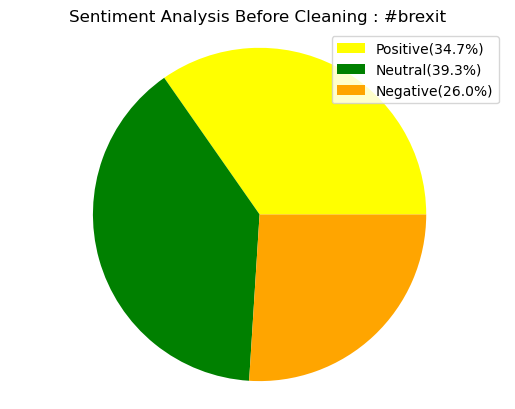

In [91]:
positive = round((100 * float(positive)/float(no_of_tweets)),1)
negative = round(100 * float(negative)/float(no_of_tweets),1)
neutral = round(100 * float(neutral)/float(no_of_tweets),1)

# Pie-Chart
labels = ['Positive('+str(positive)+'%)' , 'Neutral('+str(neutral)+'%)','Negative('+str(negative)+'%)']
sizes = [positive, neutral, negative]
colors = ['yellow', 'green','orange']
patches, texts = plt.pie(sizes,colors=colors)
plt.title('Sentiment Analysis Before Cleaning : ' + keyword )
plt.legend(labels)
plt.style.use('default')
plt.axis('equal')
plt.show()

In [92]:
### Data Analysis

In [93]:
da = tweet_list.copy()

da['word_count'] = da[0].apply(lambda x: len(str(x).split()))

def count_regex(pattern, tweet):
        return len(re.findall(pattern, tweet))

da['@_count'] = da[0].apply(lambda x: count_regex(r'@\w+', x))
da['#_count'] = da[0].apply(lambda x: count_regex(r'#\w+', x))
da['emoji_count'] = da[0].apply(lambda x: emoji.demojize(x)).apply(lambda x: count_regex(r':[a-z_&]+:', x))

In [94]:
da.head()

,0,word_count,@_count,#_count,emoji_count
0,"RT @g_gosden: ""Before Brexit you'd just wave y...",24,1,0,0
1,RT @MimiJ9: Please everyone RETWEET #DailyMail...,8,1,2,0
2,"RT @g_gosden: ""Before Brexit you'd just wave y...",24,1,0,0
3,"RT @g_gosden: ""Before Brexit you'd just wave y...",24,1,0,0
4,"RT @g_gosden: ""Before Brexit you'd just wave y...",24,1,0,0


### Data Cleaning (Duplication, RT, Punctuation etc.)

In [95]:
tweet_list.drop_duplicates(inplace = True)

twts = tweet_list.copy()
twts['text'] = twts[0]

rm_rt = lambda x: re.sub('RT @\w+: ',' ',x)
rt1 = lambda x: re.sub('(@[A-Za-z0–9]+)',' ',x)
rt2 = lambda x: re.sub('(\w+:\/\/\S+)',' ',x)

twts['text'] = twts.text.map(rm_rt)
twts['text'] = twts.text.map(rt1).map(rt2)
twts['text'] = twts.text.str.lower()

### Process tweets to detect Positive, Negative and Neutral Values

In [96]:
no_of_tweets2 = twts.shape[0]
positive2 = 0
negative2 = 0
neutral2 = 0

#Calculating Negative, Positive and Neutral Values
twts[['polarity', 'subjectivity']] = twts['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in twts['text'].iteritems():
 score = SentimentIntensityAnalyzer().polarity_scores(row)
 neg = score['neg']
 neu = score['neu']
 pos = score['pos']
     
 if neg > pos:
     twts.loc[index, 'sentiment'] = 'negative'
     negative2 += 1
 elif pos > neg:
     twts.loc[index, 'sentiment'] = 'positive'
     positive2 += 1
 else:
     twts.loc[index, 'sentiment'] = 'neutral'
     neutral2 += 1


twts_negative = twts[twts['sentiment']=='negative']
twts_positive = twts[twts['sentiment']=='positive']
twts_neutral = twts[twts['sentiment']=='neutral']

### Sentiment Analysis After Cleaning

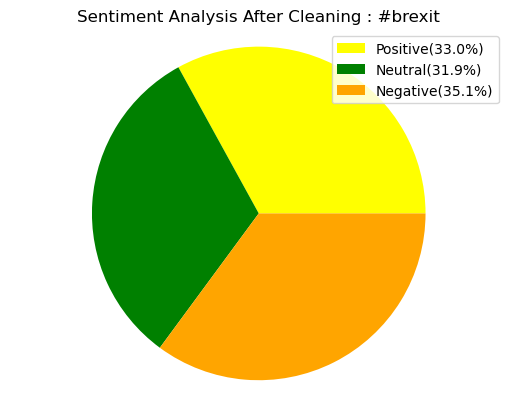

In [97]:
positive2 = round((100 * float(positive2)/float(no_of_tweets2)),1)
negative2 = round(100 * float(negative2)/float(no_of_tweets2),1)
neutral2 = round(100 * float(neutral2)/float(no_of_tweets2),1)

# Pie-Chart
labels = ['Positive('+str(positive2)+'%)' , 'Neutral('+str(neutral2)+'%)','Negative('+str(negative2)+'%)']
sizes = [positive2, neutral2, negative2]
colors = ['yellow', 'green','orange']
patches, texts = plt.pie(sizes,colors=colors)
plt.title('Sentiment Analysis After Cleaning : ' + keyword )
plt.legend(labels)
plt.style.use('default')
plt.axis('equal')
plt.show()

### Remove Unimportant Words

In [98]:
stopwords = list(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation])
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [word for word in tokens if word not in stopwords]
    text = [word for word in text if word not in ['brexit','uk','europe','british','eu','de','la','us','britain']]
    text = [word for word in text if len(word)>2]
    return text

countVectorizer = CountVectorizer(analyzer=clean_text)

In [99]:
# Process Neutral words
cv_neu = countVectorizer.fit_transform(twts_neutral['text'])

cv_neu_df = pd.DataFrame(cv_neu.toarray(), columns=countVectorizer.get_feature_names_out())
cv_neu_df = pd.DataFrame(cv_neu_df.sum())

In [100]:
# Process Positive words
cv_pos = countVectorizer.fit_transform(twts_positive['text'])

cv_pos_df = pd.DataFrame(cv_pos.toarray(), columns=countVectorizer.get_feature_names_out())
cv_pos_df = pd.DataFrame(cv_pos_df.sum()).sort_values(0,ascending=False)

In [101]:
# Process Negative words
cv_neg = countVectorizer.fit_transform(twts_negative['text'])

cv_neg_df = pd.DataFrame(cv_neg.toarray(), columns=countVectorizer.get_feature_names_out())
cv_neg_df = pd.DataFrame(cv_neg_df.sum()).sort_values(0,ascending=False)

### Wordcloud

In [102]:
def sentiment_wordcloud(text):
 stopwords = set(STOPWORDS)
 wc = WordCloud(background_color='white',max_words=3000,stopwords=stopwords,repeat=True)
 plt.imshow(wc.generate(str(text)))

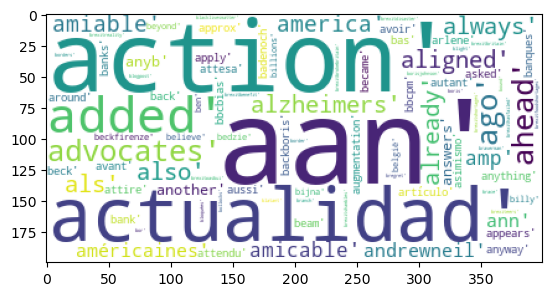

In [103]:
# Wordcloud : Neutral
sentiment_wordcloud(cv_neu_df.index.to_list())

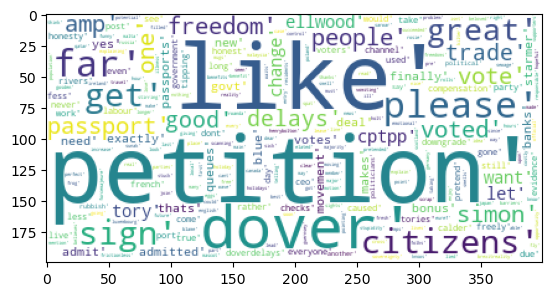

In [104]:
# Wordcloud : Positive
sentiment_wordcloud(cv_pos_df.index.to_list())

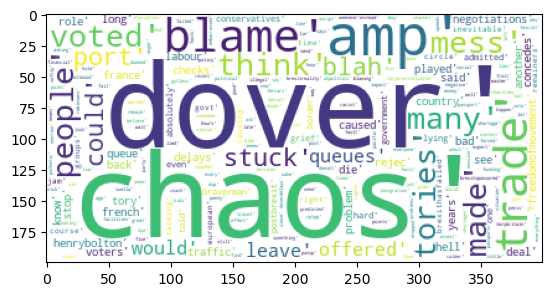

In [105]:
# Wordcloud : Negative
sentiment_wordcloud(cv_neg_df.index.to_list())